In [4]:
from pathlib import Path
from sqlalchemy import create_engine, text
from tqdm import tqdm
from datetime import datetime, date, timedelta
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)
from xgboost import XGBClassifier, plot_importance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sys

In [5]:
ROOT_DIR = Path.cwd().parent
if str(ROOT_DIR) not in sys.path:
    sys.path.append(str(ROOT_DIR))

pd.set_option('display.max_columns', None)

In [6]:
from config import DB_URI
from sklearn.metrics import (
    roc_curve, RocCurveDisplay,
    precision_recall_curve, PrecisionRecallDisplay
)
from sklearn.calibration import calibration_curve

In [7]:
engine = create_engine(DB_URI)
connection = engine.connect()

In [55]:
connection.close()  # Закрываем сломанное соединение

connection = engine.connect()  # Открываем новое чистое соединение

In [8]:
from sqlalchemy import text

query_jet = """
SELECT 
    id,
    alarm_id,
    probability,
    identifier,
    CASE 
        WHEN business_status IS NULL THEN 0
        WHEN business_status = 'Investigation' THEN 1
        ELSE NULL
    END AS business_status_numeric,
    created_at
FROM incidents
WHERE 
    identifier LIKE 'S.2%'
ORDER BY id
"""

df_jet = pd.read_sql_query(text(query_jet), connection)

print(f"Джеты: {df_jet.shape[0]} строк")

Джеты: 49281 строк


In [9]:
count_1 = (df_jet["business_status_numeric"] == 1).sum()
print(f"Количество бизнес-статусов = 1: {count_1}")

total = len(df_jet)
print(f"Общее количество строк: {total}")

percent = (count_1 / total) * 100
print(f"Процент 1: {percent:.2f}%")

Количество бизнес-статусов = 1: 7379
Общее количество строк: 49281
Процент 1: 14.97%


In [12]:
num_missing = df_jet["probability"].isna().sum()

print(f"Количество пропусков в probability: {num_missing}")

Количество пропусков в probability: 72


In [13]:
df_jet = df_jet.dropna(subset=["probability"]).reset_index(drop=True)

In [15]:
df_low_prob_real_alarm = df_jet[
    (df_jet["probability"] >= 0) & (df_jet["probability"] <= 5) & 
    (df_jet["business_status_numeric"] == 1)
]

print(f"Количество таких случаев: {len(df_low_prob_real_alarm)}")
df_low_prob_real_alarm.head()

Количество таких случаев: 495


,id,alarm_id,probability,identifier,business_status_numeric,created_at
46,149514,67eb4403ce3fbdf39c51324e,0.0,S.268656,1,2025-04-13 14:39:30.916611
101,150488,67eb60aace3fbdf39c5bbcdf,0.0,S.262532,1,2025-04-13 14:42:11.532470
124,150745,67eb65e8215780922d81bb73,0.0,S.223169,1,2025-04-13 14:43:11.727433
333,153172,67eba119110c21779e9fbd8c,0.0,S.254001,1,2025-04-13 14:48:36.828124
377,153549,67eba9f7110c21779ea0c632,0.0,S.235837,1,2025-04-13 14:49:24.685724


In [16]:
with open("low_prob_real_alarm.txt", "w", encoding="utf-8") as f:
    f.write(df_low_prob_real_alarm.to_string(index=False))


In [44]:
from sklearn.metrics import precision_score, accuracy_score

best_threshold = None
best_precision = 0
best_accuracy = 0

for threshold in range(0, 100, 1):  # 0%, 1%, ..., 99%
    t = threshold
    preds = (df_jet_after_25["probability"] > t).astype(int)
    y_true = df_jet_after_25["business_status_numeric"].fillna(0).astype(int)
    
    precision_1 = precision_score(y_true, preds, pos_label=1, zero_division=0)
    accuracy = accuracy_score(y_true, preds)
    
    if precision_1 >= 0.8:
        print(f"Threshold: {t:.2f} | Precision(1): {precision_1:.3f} | Accuracy: {accuracy:.3f}")
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_precision = precision_1
            best_threshold = t

if best_threshold is not None:
    print(f"\nЛучший threshold 16-25 апреля: {best_threshold:.2f}% с precision(1)={best_precision:.3f} и accuracy={best_accuracy:.3f}")
else:
    print("\nНе найден threshold с precision(1) >= 0.95")


Threshold: 96.00 | Precision(1): 0.815 | Accuracy: 0.863
Threshold: 97.00 | Precision(1): 0.854 | Accuracy: 0.856
Threshold: 98.00 | Precision(1): 1.000 | Accuracy: 0.850

Лучший threshold 16-25 апреля: 96.00% с precision(1)=0.815 и accuracy=0.863


In [45]:
from sklearn.metrics import precision_score, accuracy_score

best_threshold = None
best_precision = 0
best_accuracy = 0

for threshold in range(0, 100, 1):  # 0%, 1%, ..., 99%
    t = threshold
    preds = (df_jet_before_25["probability"] > t).astype(int)
    y_true = df_jet_before_25["business_status_numeric"].fillna(0).astype(int)
    
    precision_1 = precision_score(y_true, preds, pos_label=1, zero_division=0)
    accuracy = accuracy_score(y_true, preds)
    
    if precision_1 >= 0.8:
        print(f"Threshold: {t:.2f} | Precision(1): {precision_1:.3f} | Accuracy: {accuracy:.3f}")
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_precision = precision_1
            best_threshold = t

if best_threshold is not None:
    print(f"\nЛучший threshold 25-27 апреля: {best_threshold:.2f}% с precision(1)={best_precision:.3f} и accuracy={best_accuracy:.3f}")
else:
    print("\nНе найден threshold с precision(1) >= 0.95")


Threshold: 96.00 | Precision(1): 0.827 | Accuracy: 0.850
Threshold: 97.00 | Precision(1): 0.800 | Accuracy: 0.849
Threshold: 98.00 | Precision(1): 1.000 | Accuracy: 0.849

Лучший threshold 25-27 апреля: 96.00% с precision(1)=0.827 и accuracy=0.850


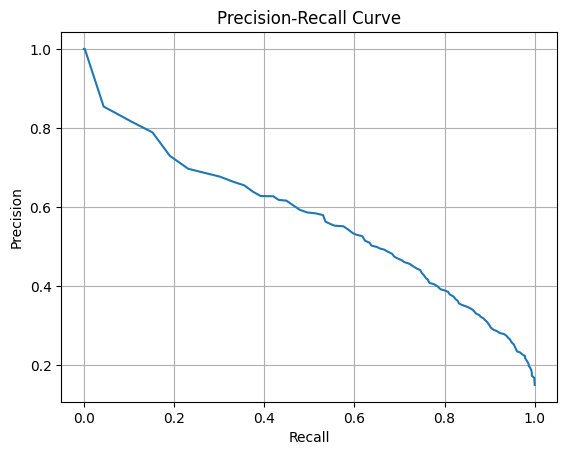

In [47]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_true = df_jet_after_25["business_status_numeric"].fillna(0).astype(int)
y_scores = df_jet_after_25["probability"]/100

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()


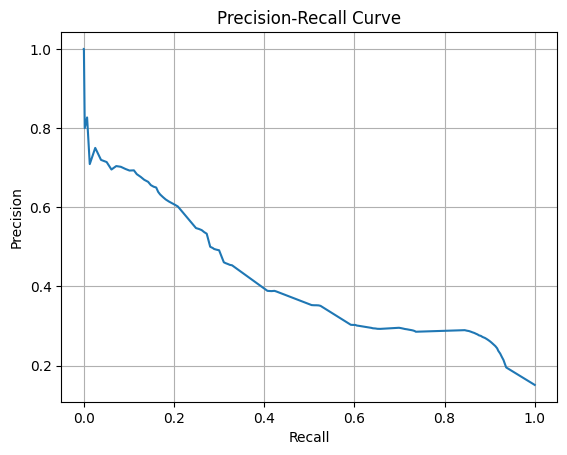

In [49]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Убираем строки, где probability был NaN
mask = df_jet_before_25["probability"].notna()

y_true = df_jet_before_25.loc[mask, "business_status_numeric"].fillna(0).astype(int)
y_scores = df_jet_before_25.loc[mask, "probability"] / 100

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()


____________________

In [50]:
df_jet_before_25

,id,probability,business_status_numeric,created_at
0,148600,0.0,0,2025-04-13 14:37:36.017751
1,148676,0.0,0,2025-04-13 14:37:44.830754
2,148709,0.0,0,2025-04-13 14:37:49.971186
3,148742,0.0,0,2025-04-13 14:37:53.310317
4,148795,45.0,1,2025-04-13 14:37:59.560333
...,...,...,...,...
39205,445626,85.0,0,2025-04-24 23:55:36.306383
39206,445647,14.0,0,2025-04-24 23:58:25.004889
39207,445649,76.0,0,2025-04-24 23:58:25.578176
39208,445653,21.0,0,2025-04-24 23:58:43.269006


In [51]:
df_jet_before_25.business_status_numeric.value_counts()

business_status_numeric
0    33284
1     5926
Name: count, dtype: int64